In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sympy as sym
from scipy import constants as const

In [3]:
data_base = pd.read_csv("tab.csv", delimiter=';')
data1 = pd.DataFrame()
data2 = pd.DataFrame()
data3 = pd.DataFrame()

data1[['f','I']] = data_base[['f_1','I_1']].dropna()
data2[['f','I']] = data_base[['f_2','I_2']].dropna()
data3[['f','I']] = data_base[['f_3','I_3']].dropna()

datas = [data1, data2, data3]

for data in datas:
    data['I'] *= 1e-3 #mA -> A

R1 = 55.2
R2 = 97.1
R3 = 266.6

L2 = 20e-3      #mH -> H 
C2 = 101.9e-9   #nF -> F

U0 = 3.001

U1 = 11.26
U2 = 8.15
U3 = 3.116


data3

,f,I
0,100,0.00012
1,300,0.00059
2,500,0.00093
3,700,0.00130
4,900,0.00168
...,...,...
59,6200,0.00162
60,6600,0.00101
61,7000,0.00056
62,7400,0.00030


In [4]:
def calc_uA(series):
    s = 0
    mean = series.mean()
    for x in series:
        s += (x - mean)**2
    s /= len(series)*(len(series)-1)
    return np.sqrt(s)

def calc_uB(Deltas):
    s = 0
    for D in Deltas:
        s += D**2 / 3
    return np.sqrt(s)

def calc_Dp_multimetr_R(rdg,dgt):
    return 0.5/100 * rdg + 2 * dgt

def calc_Dp_multimetr_C(rdg, dgt):
    return 5/100 * rdg + 10 * dgt

def calc_Dp_multimetr_U(rdg, dgt, res):
    ret = {4 : 0.8 * rdg + 3 * dgt, 40 : 2.5/100 * rdg + 5 * dgt}
    return ret[res]

def calc_Dp_multimetr_I(rdg, dgt):
    return 1/100 * rdg + 10 * dgt

def calc_Dp_f(rdg):
    if rdg < 1000:
        return 1e-6
    else:
        return 1e-5

In [5]:
data = data1
for data in datas:
    data['uf'] = data.apply(lambda row : calc_uB([ calc_Dp_f(row['f']) ]), axis=1 )
    data['uI'] = data.apply(lambda row : calc_uB([ calc_Dp_multimetr_I(row['I'], 0.01e-3) ]), axis=1)

uR1 = calc_uB([calc_Dp_multimetr_R(R1, 0.1)])
uR2 = calc_uB([calc_Dp_multimetr_R(R2, 0.1)])
uR3 = calc_uB([calc_Dp_multimetr_R(R3, 0.1)])

uL2 = 0.1 * L2

uC2 = calc_uB([ calc_Dp_multimetr_C(C2, 0.1e-9) ])

uU0 = calc_uB([ calc_Dp_multimetr_U(U0, 0.001, 4) ])

uU1 = calc_uB([ calc_Dp_multimetr_U(U1, 0.01, 40) ])
uU2 = calc_uB([ calc_Dp_multimetr_U(U2, 0.01, 40) ])
uU3 = calc_uB([ calc_Dp_multimetr_U(U3, 0.001, 4) ])


data1.head()

,f,I,uf,uI
0,100.0,0.00013,5.773503e-07,0.000058
1,300.0,0.00058,5.773503e-07,0.000061
2,500.0,0.00094,5.773503e-07,0.000063
3,700.0,0.00132,5.773503e-07,0.000065
4,900.0,0.00172,5.773503e-07,0.000068


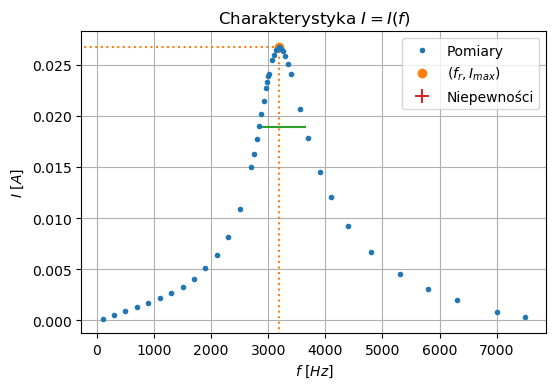

In [25]:
data = data1
UC = U1
uUC = uU1

plt.rcParams['figure.dpi'] = 100
x = data['f']
y = data['I']
xerr = data['uf']
yerr = data['uI']

plt.plot(x, y, '.', label='Pomiary', zorder=3)
plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt="none", label='Niepewności', color='C3')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())

#częstotliwość rezonansowa
f_r = x[y==y.max()].iloc[0]
uf_r = xerr[y==y.max()].iloc[0]

plt.plot(f_r, y.max(), 'o', label='$(f_r, I_{max})$')

plt.plot(np.ones(10) * f_r, np.linspace(-0.1, y.max(), 10), ":", color="C1")
plt.plot(np.linspace(-1000, f_r, 10), np.ones(10) * y.max(), ":", color="C1")

#pojemność kondensatora
C = 1 / (2*const.pi * f_r)**2 / L2
u_CC = 1 / (2*const.pi**2) * np.sqrt((uL2/(2 * f_r**2 * L2**2))**2 + (uf_r/(f_r**3 * L2))**2)

#współczynnik dobroci
QU = UC / U0
u_CQU = np.sqrt((uUC / U0)**2 + (UC * uU0 / U0**2)**2)

#wsółczynnik dobroci na podstaw. wykresu
I_sqrt2 = y.max() / np.sqrt(2)
yl = y.loc[x<f_r]
yr = y.loc[x>f_r]

#Delta f
ind_l = (yl-I_sqrt2).abs().sort_values().index[0:2]
ind_r = (yr-I_sqrt2).abs().sort_values().index[0:2]

dx_dy_l = (x.loc[ind_l].sort_index().iloc[1] - x.loc[ind_l].sort_index().iloc[0]) / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0])
dx_dy_r = (x.loc[ind_r].sort_index().iloc[1] - x.loc[ind_r].sort_index().iloc[0]) / (y.loc[ind_r].sort_index().iloc[1] - y.loc[ind_r].sort_index().iloc[0])

f1 = x.loc[ind_l].iloc[0] + (I_sqrt2 - y.loc[ind_l].iloc[0]) * dx_dy_l
f2 = x.loc[ind_r].iloc[0] + (I_sqrt2 - y.loc[ind_r].iloc[0]) * dx_dy_r

#uf1 = np.sqrt( (1)**2 * xerr.loc[ind_l].iloc[0]**2 + )


plt.plot(np.linspace(f1, f2, 10), np.ones(10) * I_sqrt2, "-")

Delta_f = f2 - f1
uDelta_f = np.sqrt((1)**2 uf2**2 + (1)**2 * f1**2)

Qf = f_r / Delta_f
uQf = np.sqrt( (1 / Delta_f)**2 * uf_r**2 + (-f_r / Delta_f**2)**2 * uDelta_f**2)



plt.title("Charakterystyka $I = I(f)$")
plt.xlabel('$f\ [Hz]$')
plt.ylabel('$I\ [A]$')
plt.grid(b=True, axis='both')
plt.legend()
plt.show()